## 1. Dataset Visualization
### 1) Goal
Before constructing the classification model, let's visualize the dataset and define the task in the first place. <br>
<b>Step 1:</b> Load and check the labels and training data.

In [1]:
import numpy as np
import pandas as pd
import sys

root_path = f'{sys.path[0]}/'
labels = pd.read_csv(root_path+'labels.csv')
data = pd.read_csv(root_path+'train.csv')

In [2]:
labels.head()

,attribute_id,attribute_name
0,0,country::afghanistan
1,1,country::alamania
2,2,country::algeria
3,3,country::arabia
4,4,country::armenia


In [3]:
data.head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


<b>Step 2:</b> Split the attribute names into catagories and types.

In [4]:
def _split_attr_names(attr_name_str):
    return [item.strip() for item in attr_name_str.split('::')] 

def _split_labels(labels_dataframe):
    split_labels_dict = dict(attribute_id=[], attr_tier1=[], attr_tier2=[])
    for i in range(labels_dataframe.shape[0]):
        tem = _split_attr_names(labels['attribute_name'][i])
        split_labels_dict['attribute_id'].append(labels['attribute_id'][i])
        split_labels_dict['attr_tier1'].append(tem[0])
        split_labels_dict['attr_tier2'].append(tem[1]) 
    split_labels = pd.DataFrame(split_labels_dict, 
                                columns=['attribute_id', 'attr_tier1', 'attr_tier2'])
    return split_labels

In [5]:
split_labels = _split_labels(labels)
split_labels.head()

,attribute_id,attr_tier1,attr_tier2
0,0,country,afghanistan
1,1,country,alamania
2,2,country,algeria
3,3,country,arabia
4,4,country,armenia


In [6]:
catagories = sorted(list(set(list(split_labels['attr_tier1']))))
print(len(catagories))

5


In [7]:
print('There are in total 5 catagories: %s, %s, %s, %s, %s.'
     %(catagories[0],
       catagories[1],
       catagories[2],
       catagories[3],
       catagories[4]))

There are in total 5 catagories: country, culture, dimension, medium, tags.


<b>Step 3:</b> Define the types of classification tasks.

In [8]:
def label_indexer_coarse(labels_dataframe):
    split_labels_dict = dict(attribute_id=[], attr_tier1=[], attr_tier2=[])
    for i in range(labels_dataframe.shape[0]):
        tem = [item.strip() for item in labels_dataframe['attribute_name'][i].split('::')] 
        split_labels_dict['attribute_id'].append(labels_dataframe['attribute_id'][i])
        split_labels_dict['attr_tier1'].append(tem[0])
        split_labels_dict['attr_tier2'].append(tem[1])
        
    split_labels = pd.DataFrame(split_labels_dict, 
                                columns=['attribute_id', 'attr_tier1', 'attr_tier2'])
    
    tier1 = dict()
    tier2 = dict()
    attr2indexing = dict()
    indexing2attr = dict()
    label_indexing_list = []
    for i_1, item1 in enumerate(sorted(list(set(list(split_labels['attr_tier1']))))):
        assert len(list(set(list(split_labels['attr_tier2'][split_labels['attr_tier1']==item1])))) \
        == len(list(split_labels['attr_tier2'][split_labels['attr_tier1']==item1]))
        tier1[item1] = i_1
        tier2[item1] = dict()
        list_tem = list(split_labels['attr_tier2'][split_labels['attr_tier1']==item1])
        for i_2, item2 in enumerate(list_tem):
            tier2[item1][item2] = i_2 + 1
    for idx in range(split_labels.shape[0]):
        tier1_idx = tier1[split_labels['attr_tier1'][idx]]
        tier2_idx = tier2[split_labels['attr_tier1'][idx]][split_labels['attr_tier2'][idx]]
        label_indexing_list.append([tier1_idx, tier2_idx])
        attr2indexing[split_labels['attribute_id'][idx]] = [tier1_idx, tier2_idx]
        indexing2attr[str([tier1_idx, tier2_idx])] = split_labels['attribute_id'][idx]
    labels_indexing_df = split_labels.copy()
    labels_indexing_df['indexing'] = label_indexing_list
    return labels_indexing_df, attr2indexing, indexing2attr
labels_indexing_df, attr2indexing, indexing2attr = label_indexer_coarse(labels)

count_array = np.zeros((data.shape[0], 6), dtype='int')
for i, attr_ids in enumerate(data['attribute_ids']):
    cata_indexing = [labels_indexing_df['indexing'][int(attr_id)][0] 
                     for attr_id in data['attribute_ids'][i].split()]
    for i_ in range(count_array.shape[1]):
        count_array[i, i_] = cata_indexing.count(i_)
for i_tier1, tier1 in enumerate(sorted(list(set(list(split_labels['attr_tier1']))))):
    print('Catagory: %s; minimum count of tagging per item: %s; maximum count of tagging per item: %s' 
          %(tier1, np.amin(count_array, axis=0)[i_tier1], np.amax(count_array, axis=0)[i_tier1]))

Catagory: country; minimum count of tagging per item: 0; maximum count of tagging per item: 3
Catagory: culture; minimum count of tagging per item: 0; maximum count of tagging per item: 4
Catagory: dimension; minimum count of tagging per item: 0; maximum count of tagging per item: 1
Catagory: medium; minimum count of tagging per item: 0; maximum count of tagging per item: 17
Catagory: tags; minimum count of tagging per item: 0; maximum count of tagging per item: 18


In [9]:
label_count_array = np.zeros((len(labels['attribute_id'])), dtype='int')
for i in range(len(data['attribute_ids'])):
    for label in [int(attr_id) for attr_id in data['attribute_ids'][i].split()]:
        label_count_array[label] += 1

In [10]:
np.mean(label_count_array[0: 100]/len(data))

0.001796241178167592

In [11]:
np.mean(label_count_array[100: 781]/len(data))

0.0010461130487956674

In [12]:
np.mean(label_count_array[786: 2706]/len(data))

0.0007177597060679196

In [13]:
np.mean(label_count_array[2706: 3474]/len(data))

0.0018646437287296797

In [16]:
1/(np.array([1-np.sum(label_count_array[781: 785]/len(data)), label_count_array[781: 785][0]/len(data),
 label_count_array[781: 785][1]/len(data), label_count_array[781: 785][2]/len(data), 
 label_count_array[781: 785][3]/len(data)]))

array([2.33663806, 6.72211711, 6.87495163, 7.14848348, 7.25022957])

In [20]:
np.array([1-np.sum(label_count_array[781: 786]/len(data)), label_count_array[781: 786][0]/len(data),
 label_count_array[781: 786][1]/len(data), label_count_array[781: 786][2]/len(data), 
 label_count_array[781: 786][3]/len(data), label_count_array[781: 786][4]/len(data)])

array([0.28261527, 0.14876266, 0.14545557, 0.13988981, 0.13792667,
       0.14535002])

In [21]:
label_count_array[781: 786]

array([21142, 20672, 19881, 19602, 20657])

Finally, let's check the minimum and maximum amount of attributes per item.

In [14]:
print('The minimum amount of attributes of the images: %s'
      %min([len(data['attribute_ids'][i].split()) for i in range(len(data['attribute_ids']))]))
print('The maximum amount of attributes of the images: %s'
      %max([len(data['attribute_ids'][i].split()) for i in range(len(data['attribute_ids']))]))

The minimum amount of attributes of the images: 1
The maximum amount of attributes of the images: 26


### 2) Tasks
As the counting results shown, an object can only have one single label in catagory "dimension", but it may have multiple labels in another 4 catagories.<br>
Hence, we define the classification task of catagory "dimension" as multi-class classification and the tasks of the other 4 catagories as multi-label classification. <br>
We decided to train a multi-head CNN model to complete this task. An pretrained ResNet architecture will co-train with 5 classifier heads. The second classifier will perform the multi-class classification (In total 6 classes; 0 means no label being eligible). The other 4 classifiers will perform multi-label classification.  

## 2. Model constructing and training
let's start constructing the classification model.
### 1) Library and codes
The codes are also available on GitHub (https://github.com/yunchen-yang/artcv).

### 2) Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import torch
import torch.nn.functional as F
from artcv.model import ArtCV
from artcv.trainer import Trainer
from artcv.datatool import ImgDataset, TrainValSet
import sys
from artcv.utils import f2score, regularized_pred
from artcv.groups_info import _label_groups3_40
torch.cuda.is_available()

True

In [2]:
_root_path = sys.path[0]
path = f'{_root_path}/train'
data_info_path = f'{_root_path}/train.csv'
labels_info_path = f'{_root_path}/labels.csv'
dataset = TrainValSet(train_val_split=False, train_transform='val',
                      path=path, data_info_path=data_info_path, labels_info_path=labels_info_path)

In [3]:
tag='50'
weight_path = f'{_root_path}/pretrained/resnet{tag}.pth'
model = ArtCV(tag=tag, weight_path=weight_path, freeze_cnn=True, dropout_rate=0.1, weights=(1, 1, 10, 1, 1),
              classifier_layers=(2,2,2,2,2), focal_loss=False, focal_loss_mc=False,
              alpha=(0.25, 0.25, 0.25, 0.25), alpha_mc=(0.25, 0.75, 0.75, 0.75, 0.75, 0.75),
              gamma_mc=2, gamma=(2, 2, 2, 2), alpha_t=True, alpha_t_mc=True,
              hierarchical=False, label_groups=(0, 1, 2, 1, 1, 1), 
              alpha_group=(1, 1), gamma_group=2, weight_group=5,
              hierarchical_ml=(False, True, True, True), label_groups3=_label_groups3_40)

# file_name = 'frozen_no_crop_resnet50_2layer_9_1_epochs_reduced_lr.model.pkl'
# save_path = f'{_root_path}/weights/{file_name}'
# model.load_state_dict(torch.load(save_path))

In [4]:
trainer = Trainer(model, dataset, extra_epochs_mc=1, train_mc_step=2,
                  batch_size_train=256, batch_size_val=512, batch_size_all=128,
                  epochs=8, compute_acc=False, head_log=True,
                  monitor_frequency=False,
                  dataloader_train_kwargs={'num_workers':4}, dataloader_val_kwargs={'num_workers':4},
                  dataloader_all_kwargs={'num_workers':4})

In [5]:
trainer.train(lr=1e-2, mc_lr=2e-3, reduce_lr=True, reduce_lr_mc=True,
              step=2, gamma=0.8, step_mc=2, gamma_mc=0.8)
file_name = 'frozen_hier_ml134_no_crop_resnet50_2layer_8_4_epochs_reduced_lr.model.pkl'
save_path = f'{_root_path}/weights/{file_name}'
torch.save(trainer.model.state_dict(), save_path)

Training progress: 100%|██████████| 8/8 [2:28:54<00:00, 1116.87s/it]  


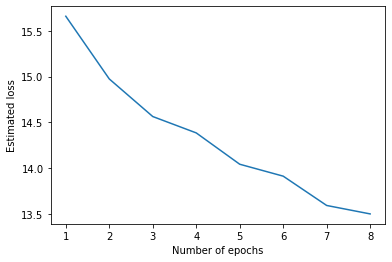

In [6]:
trainer.plot_running_loss(epochs_override=8)

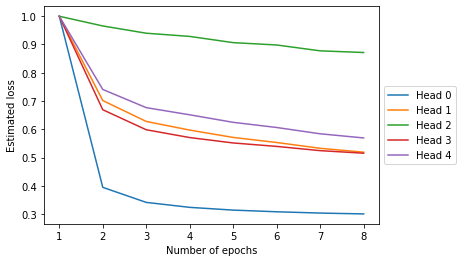

In [7]:
trainer.plot_head_loss(epochs_override=8)

In [8]:
gt, probs = trainer.get_probs(tag='all')

In [9]:
thre=(0.15, 0.15, 0.15, 0.15)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.7389556113954125

In [10]:
thre=(0.1, 0.1, 0.1, 0.1)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.739603479183102

In [11]:
thre=(0.1, 0.1, 0.2, 0.2)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.7276659377901858

In [12]:
thre=(0.08, 0.08, 0.08, 0.08)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.7325400247340625

In [13]:
thre=(0.5, 0.5, 0.5, 0.5)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5988959310586687

In [ ]:
trainer.compute_hier_acc(tag='all')

In [22]:
file_name = 'frozen_no_crop_resnet50_2layer_9_1_epochs_reduced_lr_probs.npz'
save_path = f'{_root_path}/weights/{file_name}'
scipy.sparse.save_npz(save_path, scipy.sparse.csc_matrix(probs))

In [21]:
file_name = 'frozen_no_crop_resnet50_2layer_9_1_epochs_reduced_lr_gt.npz'
save_path = f'{_root_path}/weights/{file_name}'
scipy.sparse.save_npz(save_path, scipy.sparse.csc_matrix(gt))

In [11]:
pred = regularized_pred(probs, thre=(0.1, 0.1, 0.1, 0.1))
file_name = 'frozen_no_crop_resnet50_2layer_9_1_epochs_reduced_lr_pred_0_1.npz'
save_path = f'{_root_path}/weights/{file_name}'
scipy.sparse.save_npz(save_path, scipy.sparse.csc_matrix(pred))

In [12]:
pred = regularized_pred(probs, thre=(0.15, 0.15, 0.15, 0.15))
file_name = 'frozen_no_crop_resnet50_2layer_9_1_epochs_reduced_lr_pred_0_15.npz'
save_path = f'{_root_path}/weights/{file_name}'
scipy.sparse.save_npz(save_path, scipy.sparse.csc_matrix(pred))

In [14]:
from sklearn.metrics import fbeta_score
def f2score(ground_truth, probs, thre, boundary=([0, 100], [100, 781], [786, 2706], [2706, 3474]), return_mean=True):
    if type(thre) == float:
        thre = (thre, thre, thre, thre)
    predictions = np.zeros(probs.shape, dtype='int')
    for i in range(len(boundary)):
        predictions[:, boundary[i][0]: boundary[i][1]][
            probs[:, boundary[i][0]: boundary[i][1]] > thre[i]] = 1
    f_beta = [fbeta_score(ground_truth[i,:], predictions[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

f2score(gt, probs, thre=(0.9, 0.9, 0.9, 0.9))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3579200298481132

In [13]:
probs

array([[2.6106884e-04, 1.7909489e-04, 1.9444959e-04, ..., 1.5007920e-04,
        3.3099386e-05, 3.7575264e-05],
       [2.9602909e-04, 1.7483300e-04, 9.1748596e-05, ..., 1.5546074e-04,
        6.4731445e-05, 3.5735796e-04],
       [5.8983109e-04, 1.3339572e-04, 6.9576156e-05, ..., 1.4511746e-04,
        1.4496795e-04, 2.4014462e-05],
       ...,
       [6.5902882e-06, 9.7008131e-05, 1.4387113e-05, ..., 3.6465921e-04,
        3.0311960e-04, 1.3570673e-03],
       [7.4060721e-04, 1.2655444e-04, 1.5167437e-04, ..., 1.5082318e-04,
        6.4485165e-04, 1.5801283e-05],
       [6.6598353e-05, 1.4439943e-04, 8.5993270e-05, ..., 2.1885346e-04,
        1.8617623e-04, 1.0107508e-04]], dtype=float32)

In [18]:
np.where(probs[51, :]>0.06)[0]

array([ 784,  800, 2362, 2714, 3263, 3465])

In [15]:
np.where(gt[51, :]==1)[0]

array([ 784,  800, 2714, 3263, 3465])

In [4]:
# _root_path = sys.path[0]
# path = f'{_root_path}/train'
# test_path = f'{_root_path}/test'
# data_info_path = f'{_root_path}/train.csv'
# labels_info_path = f'{_root_path}/labels.csv'
# dataset = TrainValSet(train_val_split=False, path=path, 
#                       data_info_path=data_info_path, labels_info_path=labels_info_path,
#                       test_path=test_path)
tag='50'
weight_path = f'{_root_path}/pretrained/resnet{tag}.pth'
model = ArtCV(tag=tag, weight_path=weight_path, freeze_cnn=4, dropout_rate=0, 
              weights=(1, 1, 1, 1, 1), classifier_layers=(2, 2, 2, 2, 2),
              focal_loss=True, alpha=0.25, gamma=2)

trainer = Trainer(model, dataset, batch_size_train=512, batch_size_val=512, batch_size_all=128,
                  batch_size_test=64,
                  epochs=15, compute_acc=False,
                  monitor_frequency=3,
                  dataloader_train_kwargs={'num_workers':2}, dataloader_val_kwargs={'num_workers':2},
                  dataloader_all_kwargs={'num_workers':2})

file_name = 'frozen_focal_loss_resnet50_2layer_equal_weights_50epochs_reduced_lr.model.pkl'
save_path = f'{_root_path}/weights/{file_name}'
model.load_state_dict(torch.load(save_path))

In [7]:
gt, probs = trainer.get_probs(tag='all')

In [ ]:
from artcv.utils import f2score
predictions = np.zeros(probs.shape, dtype='int')
predictions[probs > 0.5] = 1
f2score(gt, predictions)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
thre=(0.5, 0.5, 0.5, 0.5)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.43679737507162547

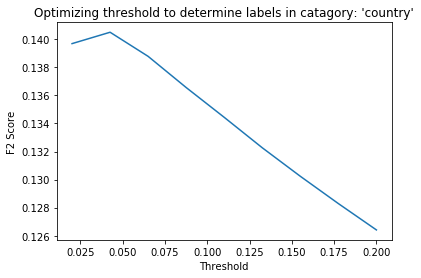

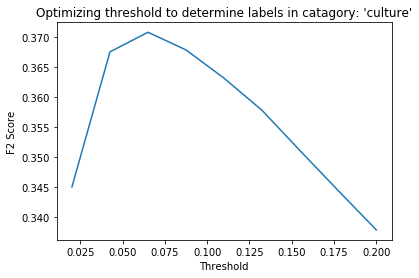

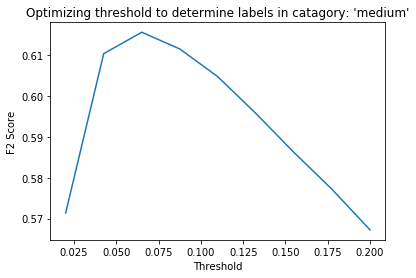

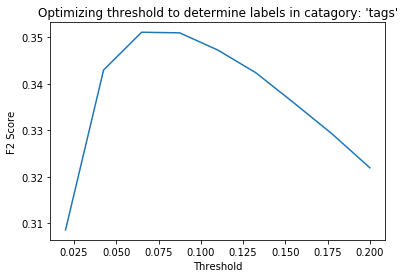

In [29]:
from sklearn.metrics import fbeta_score

def f2score_single_thre(ground_truth, probs, thre, return_mean=True):
    predictions = np.zeros(probs.shape, dtype='int')
    predictions[probs > thre] = 1
    f_beta = [fbeta_score(ground_truth[i,:], predictions[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

boundary = ([0, 100], [100, 781], [786, 2706], [2706, 3474])
catagories = ('country', 'culture', 'medium', 'tags')
fb = dict()
for i, catagory in enumerate(catagories):
    fb[catagory]=[]
    for i_ in range(2, 20, 2):
        thre = 0.01*i_
        fb[catagory].append(f2score_single_thre(gt[:, boundary[i][0]: boundary[i][1]], probs[:, boundary[i][0]: boundary[i][1]], thre=thre))

    len_ticks = len(fb[catagory])
    x_axis = np.linspace(0.02, 0.2, len_ticks)
    plt.figure()

    plt.plot(x_axis, fb[catagory])
    plt.title("Optimizing threshold to determine labels in catagory: '%s'"
             %catagory)
    plt.xlabel('Threshold')
    plt.ylabel('F2 Score')
    plt.show()


In [30]:
def f2score(ground_truth, probs, thre, boundary=([0, 100], [100, 781], [786, 2706], [2706, 3474]), return_mean=True):
    if type(thre) == float:
        thre = (thre, thre, thre, thre)
    predictions = np.zeros(probs.shape, dtype='int')
    for i in range(len(boundary)):
        predictions[:, boundary[i][0]: boundary[i][1]][
            probs[:, boundary[i][0]: boundary[i][1]] > thre[i]] = 1
    f_beta = [fbeta_score(ground_truth[i,:], predictions[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

f2score(gt, probs, thre=(0.04, 0.06, 0.06, 0.06))

0.5189223106200906

In [9]:
thre=(0.04, 0.06, 0.06, 0.06)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5693199511624866

In [10]:
thre=(0.06, 0.06, 0.06, 0.06)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5701082419552248

In [11]:
thre=(0.08, 0.08, 0.08, 0.08)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5729043735269962

In [12]:
thre=(0.1, 0.1, 0.1, 0.1)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5714427257164598

In [15]:
file_name_gt = 'frozen_resnet50_2layer_15epochs_reduced_lr_gt.npy'
save_path_gt = f'{_root_path}/weights/{file_name_gt}'
np.save(save_path_gt, gt)

In [16]:
file_name_probs = 'frozen_resnet50_2layer_15epochs_reduced_lr_probs.npy'
save_path_probs = f'{_root_path}/weights/{file_name_probs}'
np.save(save_path_probs, probs)

In [8]:
_root_path = sys.path[0]
path = f'{_root_path}/train'
test_path = f'{_root_path}/test'
data_info_path = f'{_root_path}/train.csv'
labels_info_path = f'{_root_path}/labels.csv'
dataset = TrainValSet(train_val_split=False, path=path, 
                      data_info_path=data_info_path, labels_info_path=labels_info_path,
                      test_path=test_path)
tag='50'
weight_path = f'{_root_path}/pretrained/resnet{tag}.pth'
model = ArtCV(tag=tag, weight_path=weight_path, freeze_cnn=True, dropout_rate=0, weights=(1, 1, 2, 1, 1), classifier_layers=(2, 2, 1, 2, 2))

trainer = Trainer(model, dataset, batch_size_train=512, batch_size_val=512, batch_size_all=256,
                  batch_size_test=256,
                  epochs=15, compute_acc=False,
                  monitor_frequency=3,
                  dataloader_train_kwargs={'num_workers':2}, dataloader_val_kwargs={'num_workers':2},
                  dataloader_all_kwargs={'num_workers':2})

file_name = 'frozen_resnet50_2layer_15epochs_reduced_lr.model.pkl'
save_path = f'{_root_path}/weights/{file_name}'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [12]:
np.where(probs[34657,:]>0.06)

(array([783]),)

In [13]:
np.where(gt[34657,:]==1)

(array([2103, 2914, 2932, 3079, 3170, 3465]),)